# Calibrate Model via Abundance Matching at z=4


In [1]:
# import modules

import numpy as np
from astropy.cosmology import WMAP7 as cosmo
import astropy.units as u
from astropy.table import Table
import h5py
from hmf import MassFunction
import fsps

import make_SFH
import read_in_halo_cat
import derive_SP_prop
import completeness

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'


In [2]:
# define paths

path_main = '/Users/sandrotacchella/ASTRO/JWST/Halo_Model/'
path_figures = path_main + 'Figures/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SFH_cat = path_main + 'catalogs/SFH/'
path_SP_cat = path_main + 'catalogs/SP/'


# set SFH option

SFH_type_option = 'constant'


In [3]:
# define functions

def compute_HMF(mass_list, mass_bins, volume_box):
    idx_good = np.isfinite(np.log10(mass_list))
    hist_zX, bin_edges = np.histogram(np.log10(mass_list[idx_good]), bins=mass_bins)
    HMFcum_zX = np.cumsum(hist_zX[::-1])[::-1]/(volume_box)
    return(HMFcum_zX)


def get_analytical_HMF(redshift):
    '''
    PS, Jenkins, SMF, Warren, Tinker08 
    '''
    HMF = MassFunction(cosmo_model=cosmo, z=redshift, Mmin=8, Mmax=15, hmf_model='SMT')
    cumulative_mass_func = HMF.ngtm*cosmo.h**3
    masses = HMF.m/cosmo.h
    return(masses, cumulative_mass_func)





# Construct DM halo mass function

In [4]:
# read in catalog

z_table_z4, M_table_z4, Mt_table_z4 = read_in_halo_cat.read_in_halo_cat(path_DM_cat + 'MergerHistory_COLOR_CDM_z3.96.hdf5', cosmo)




[ 8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3
  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5]


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


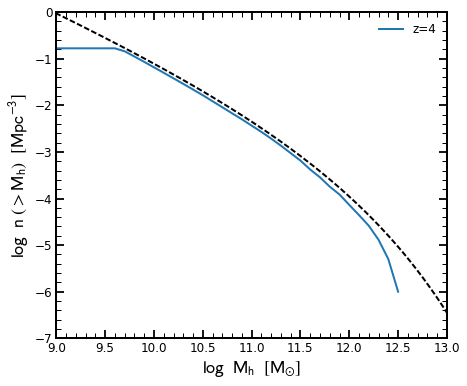

In [5]:
# construct halo mass function

min_mass = 9.0
max_mass = 13.5
volume_box = 100.0**3  # in Mpc^-3

mass_bins = np.linspace(8.0, 13.5, num=56)
print mass_bins
mass_bins_left = mass_bins[:-1]
mass_bins_center = mass_bins[:-1]+0.5*np.diff(mass_bins)

HMF_z4 = compute_HMF(M_table_z4, mass_bins, volume_box)


# get analytical halo mass function

HMF_analytic_z4 = get_analytical_HMF(4.0)


# plot HMF

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

ax.plot(mass_bins_left, np.log10(HMF_z4), '-', lw=2, label='z=4')
ax.plot(np.log10(HMF_analytic_z4[0]), np.log10(HMF_analytic_z4[1]), '--', color='black', lw=2) 

ax.set_xlabel(r'$\log\/\/\/\/\mathrm{M}_{\rm h}\/\/\/\/[\mathrm{M}_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\mathrm{n}\/\/(>\mathrm{M}_{\rm h})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([9, 13])
ax.set_ylim([-7.0, 0.0])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'Tests/HaloMF_z4.pdf', bbox_inches='tight')
plt.show()



# Abundance Matching

Details of abundance matching:

1. Obtain L_UV(Mh, z=4) by abundance matching: n(>Mh) = rho(>LUV), where n is the cumulative halo mass function and rho is the cumulative UV LF.

2. Get epsilon by comparing predicted L_UV(Mh, z=4) from epsilon = 1.0 and L_UV(Mh, z=4) from abundance matching => get distribution function


In [6]:
# define functions

def get_dust_attenuation(magUV_in, redshift_in, with_scatter=False):
    '''
    This function computes the dust attenuation at 1600 A (A1600)
    from the Bouwens et al 2015 relation.
    '''
    # ensure inputs are arrays
    if type(magUV_in) is not np.ndarray:
        magUV_in = np.array([magUV_in])
    if type(redshift_in) is not np.ndarray:
        redshift_in = np.array([redshift_in])
    # values for beta-MUV relation from Bouwens et al 2015
    B15_z_list = np.array([2.5, 3.8, 5.0, 5.9, 7.0, 8.0])
    B15_beta_list = np.array([-1.70, -1.85, -1.91, -2.00, -2.05, -2.13])
    B15_dbdM_list = np.array([-0.20, -0.11, -0.14, -0.20, -0.20, -0.15])
    # interpolate beta-MUV relation
    beta_value = np.interp(redshift_in, B15_z_list, B15_beta_list, left=B15_beta_list[0], right=np.nan)
    dbdM_value = np.interp(redshift_in, B15_z_list, B15_dbdM_list, left=B15_dbdM_list[0], right=np.nan)
    # get average beta
    avg_b = dbdM_value*(magUV_in+19.5) + beta_value
    # convert beta to A1600
    if with_scatter:
        A1600 = 4.43 + 1.99*(avg_b + np.random.normal(loc=0.0, scale=0.34, size=len(avg_b)))
    else:
        A1600 = 4.43 + 0.2*np.log(10)*1.99**2*0.34**2+1.99*avg_b
    A1600[np.isnan(A1600)] = np.zeros(np.sum(np.isnan(A1600)))
    A1600[A1600 < 0.0] = np.zeros(np.sum(A1600 < 0.0))
    return(A1600)


def UV_LF_Bouwens15(mag_in, z, do_dust_corr=True, with_scatter=False):
    '''
    This returns the UV LF (mags and phis) of Bouwens et al 2015.
    '''
    # Bouwens et al 2015
    MUV = -20.95+0.01*(z-6.0)
    phi = 0.47*np.power(10, -0.27*(z-6.0))*10**-3  # in Mpc
    alpha = -1.87-0.1*(z-6.0)
    if do_dust_corr:
        AUV = get_dust_attenuation(mag_in, z, with_scatter=with_scatter)
        mag = mag_in - AUV
    else:
        mag = mag_in
    return(mag, phi*(np.log(10)/2.5)*np.power(10, -0.4*(mag_in-MUV)*(alpha+1.0))*np.exp(-1.0*np.power(10.0, -0.4*(mag_in-MUV))))


def matching(UV_LF, HMF, Mh_list, redshift):
    '''
    This function returns a UV luminosity (at 1600 A) given a dark matter halo mass
    assuming a halo mass function and a UV luminosity function (cumulative).
    '''
    lum_dist = cosmo.luminosity_distance(redshift).to(u.cm).value
    num_density = np.interp(Mh_list, HMF[0], HMF[1], left=np.nan, right=np.nan)
    UV_mag = np.interp(num_density, UV_LF[1], UV_LF[0], left=np.nan, right=np.nan)
    L_1600 = 4*np.pi*(3.086e+19)**2*np.power(10, -0.4*(UV_mag+48.6))  # in order to make it erg/s (instead of Lsun)
    return(L_1600)



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


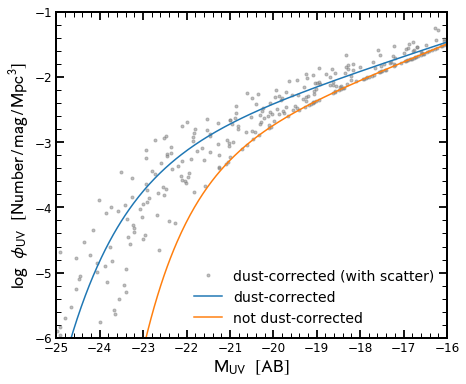

In [7]:
# get luminosity functions (dust and not dust corrected)

list_mag_in = np.linspace(-30.0, -5.0, num=1000)
list_mag, phi_mag = UV_LF_Bouwens15(list_mag_in, 4.0, do_dust_corr=True)
list_mag_wscatter, phi_mag_wscatter = UV_LF_Bouwens15(list_mag_in, 4.0, do_dust_corr=True, with_scatter=True)
list_mag_not_dust_corrected, phi_mag_not_dust_corrected = UV_LF_Bouwens15(list_mag_in, 4.0, do_dust_corr=False)


# plot luminosity functions

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

ax.plot(list_mag_wscatter, np.log10(phi_mag_wscatter), '.', label='dust-corrected (with scatter)', color='gray', alpha=0.5)
ax.plot(list_mag, np.log10(phi_mag), '-', label='dust-corrected')
ax.plot(list_mag_not_dust_corrected, np.log10(phi_mag_not_dust_corrected), '-', label='not dust-corrected')

ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/[\mathrm{Number}\//\/\mathrm{mag}\//\/\mathrm{Mpc}^{3}]$', fontsize=18)

ax.set_xlim([-25.0, -16])
ax.set_ylim([-6.0, -1.0])


plt.legend(frameon=False, fontsize=14)  
plt.savefig(path_figures + 'Calibration/UV_LF_dustcorrection.pdf', bbox_inches='tight')
plt.show()



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


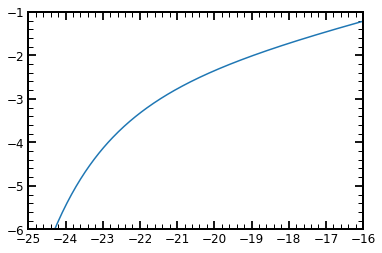

In [8]:
# determine the cumulative UV LF

phi_UV_cum = []

for ii_mag in list_mag:
    idx = (list_mag < ii_mag)
    phi_UV_cum = np.append(phi_UV_cum, np.trapz(phi_mag[idx], list_mag[idx]))


plt.xlim([-25.0, -16])
plt.ylim([-6.0, -1.0])

plt.plot(list_mag, np.log10(phi_UV_cum), '-')
plt.show()



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


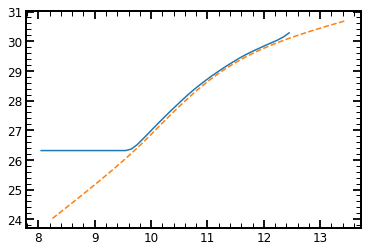

[2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.31796134e+26 3.21801975e+26 4.95551896e+26 7.74321964e+26
 1.21613214e+27 1.89645463e+27 2.93455689e+27 4.49939089e+27
 6.82264594e+27 1.03103396e+28 1.53969538e+28 2.24873694e+28
 3.20535919e+28 4.49266997e+28 6.19957530e+28 8.41908212e+28
 1.13318101e+29 1.50870110e+29 1.97014130e+29 2.56888842e+29
 3.28168848e+29 4.11358078e+29 5.05262678e+29 6.16170898e+29
 7.54621925e+29 9.08177305e+29 1.10595005e+30 1.39955177e+30
 1.91011283e+30            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan]
[           nan            nan 1.06429021e+24 1.49778242e+24
 2.11146711e+24 2.98222998e+24 4.22093396e+24 5.98806774e+24
 8.51694415e+24 1.21487990e+25 1.73858

In [9]:
# do the abundance matching and plot LUV-Mhalo relation

Mh_list = mass_bins_center
LUV_Mh = matching([list_mag, np.log10(phi_UV_cum)], [mass_bins_left, np.log10(HMF_z4)], Mh_list, 4.0)
LUV_Mh2 = matching([list_mag, np.log10(phi_UV_cum)], [np.log10(HMF_analytic_z4[0]), np.log10(HMF_analytic_z4[1])], Mh_list, 4.0)

plt.plot(Mh_list, np.log10(LUV_Mh), '-')
plt.plot(Mh_list, np.log10(LUV_Mh2), '--')
plt.show()

print LUV_Mh
print LUV_Mh2



# Determine efficiency epsilon

In [10]:
# read in UV catalog based on epsilon=1.0 run

cat_z4 = h5py.File(path_SP_cat + 'SFH_z4_constant_calibration_with_L.hdf5', 'r')



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


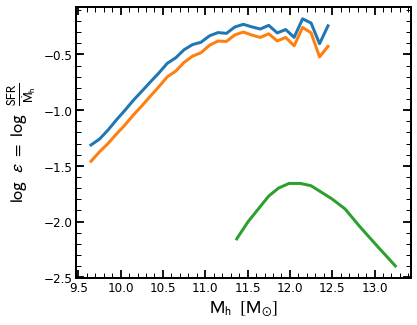

In [11]:
# determine epsilon: for a given Mh, you should get LUV (as given by LUV_Mh)

# bin epsilon in order to save it

epsilon_bins = np.linspace(-3.0, 5.0, num=501)
epsilon_bin_center = epsilon_bins[:-1] + 0.5*np.diff(epsilon_bins)
epsilon_hist2d = epsilon_bin_center

epsilon_16pers = []
epsilon_median = []
epsilon_84pers = []
epsilon2_16pers = []
epsilon2_median = []
epsilon2_84pers = []

for ii_M in range(len(mass_bins)-1):
    index = (np.log10(cat_z4['DM/DM_M'][:]) >= mass_bins[ii_M]) & (np.log10(cat_z4['DM/DM_M'][:]) < mass_bins[ii_M+1])
    LUV_distribution = cat_z4['luminosities/luminosity_0'][:, 2][index]
    if (np.isnan(LUV_Mh[ii_M])) | (np.sum(index) == 0.0):
        epsilon_hist2d = np.vstack([epsilon_hist2d, np.nan*np.ones(len(epsilon_bin_center))])
        epsilon_16pers = np.append(epsilon_16pers, np.nan)
        epsilon_median = np.append(epsilon_median, np.nan)
        epsilon_84pers = np.append(epsilon_84pers, np.nan)
        epsilon2_16pers = np.append(epsilon2_16pers, np.nan)
        epsilon2_median = np.append(epsilon2_median, np.nan)
        epsilon2_84pers = np.append(epsilon2_84pers, np.nan)
    else:
        idx = (LUV_distribution > 0.0)
        epsilon_distribution = LUV_Mh[ii_M]/LUV_distribution[idx]
        hist, bin_edges = np.histogram(np.log10(epsilon_distribution), bins=epsilon_bins, density=True)
        epsilon_hist2d = np.vstack([epsilon_hist2d, hist])
        epsilon_16pers = np.append(epsilon_16pers, np.percentile(epsilon_distribution, 16))
        epsilon_median = np.append(epsilon_median, np.percentile(epsilon_distribution, 50))
        epsilon_84pers = np.append(epsilon_84pers, np.percentile(epsilon_distribution, 84))
        epsilon2_distribution = LUV_Mh2[ii_M]/LUV_distribution[idx]
        epsilon2_16pers = np.append(epsilon2_16pers, np.percentile(epsilon2_distribution, 16))
        epsilon2_median = np.append(epsilon2_median, np.percentile(epsilon2_distribution, 50))
        epsilon2_84pers = np.append(epsilon2_84pers, np.percentile(epsilon2_distribution, 84))


# cheap comparison Behroozi

Mh_Behroozi13 = [2.353e11, 3.210e11, 5.639e11, 7.352e11, 9.748e11, 1.331e12, 1.775e12, 3.135e12, 4.480e12, 6.709e12, 1.082e13, 1.762e13]
MM_Behroozi13 = [0.007, 0.010, 0.017, 0.020, 0.022, 0.022, 0.021, 0.016, 0.013, 0.009, 0.006, 0.004]


# plot luminosity functions

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(Mh_list, np.log10(epsilon_median), '-', lw=3)
ax.plot(Mh_list, np.log10(epsilon2_median), '-', lw=3)
#ax.fill_between(Mh_list, np.log10(epsilon_16pers), np.log10(epsilon_84pers), alpha=0.2)

ax.plot(np.log10(Mh_Behroozi13), np.log10(MM_Behroozi13), '-', lw=3)

ax.set_xlabel(r'$\mathrm{M}_{\rm h}\/\/\/\/[\mathrm{M}_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\epsilon\/\/=\/\/\log\/\/\/\/\frac{\rm SFR}{\rm \dot{M}_{\rm h}}$', fontsize=18)

#ax.set_xlim([-25.0, -16])
#ax.set_ylim([-6.0, -1.0])

plt.legend(frameon=False, fontsize=14)  
plt.savefig(path_figures + 'Calibration/efficency_' + SFH_type_option + '.pdf', bbox_inches='tight')
plt.show()


In [12]:
# re-format epsilon

halo_info = np.append(-1, Mh_list)[np.newaxis]
epsilon_hist2d_complete = np.hstack([halo_info.T, epsilon_hist2d])

# save epsilon

np.save(path_SFH_cat + 'calibration/epsilon_' + SFH_type_option + '.npy', epsilon_hist2d_complete)
np.save(path_SFH_cat + 'calibration/epsilon_' + SFH_type_option + '_median.npy', np.array([Mh_list, np.log10(epsilon_median), np.log10(epsilon_16pers), np.log10(epsilon_84pers)]))
np.save(path_SFH_cat + 'calibration/epsilon2_' + SFH_type_option + '_median.npy', np.array([Mh_list, np.log10(epsilon2_median), np.log10(epsilon2_16pers), np.log10(epsilon2_84pers)]))



In [13]:

import numpy as np
import h5py


def read_in_efficency(file_name):
    '''
    Reads in and manipulates dark matter halo accretion history.
    '''
    # read in catalog
    epsilon_info = np.load(file_name)
    epsilon_info_Mh = epsilon_info[0]
    epsilon_info_epsi = epsilon_info[1]
    # define epsilon function
    def draw_epsilon(Mh_in, size_in=1.0):
        '''
        This function returns an efficency from
        the calibrated distribution for a given halo mass.
        '''
        idx_Mh = np.abs(epsilon_info_Mh-Mh_in).argmin()
        epsilon_median = epsilon_info_epsi[idx_Mh]
        if np.isnan(epsilon_median):
            epsilon_median = np.nanmin(epsilon_info_epsi)
        return(epsilon_median*np.ones(size_in))
    return(draw_epsilon)





In [14]:
e_fct = read_in_efficency(path_SFH_cat + 'calibration/epsilon2_' + SFH_type_option + '_median.npy')


In [15]:
print e_fct(12.5)


TypeError: 'float' object cannot be interpreted as an index